In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import time
import itertools
import pickle
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import sys
sys.path.append("..")
from tools.flight_projection import *
from tools.conflict_handling import *

import seaborn as sns
sns.set(color_codes=True)

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
def f1_score(p_dict):
    
    tp, fp, tn, fn = p_dict['TP'], p_dict['FP'], p_dict['TN'], p_dict['FN']
    
    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    
    f1 = 2*(1/(1/prec + 1/rec))
    
    return f1


def fx_score(p_dict, x):
    tp, fp, tn, fn = p_dict['TP'], p_dict['FP'], p_dict['TN'], p_dict['FN']

    if tp + fp == 0:
        return 0
        
    if tp + fn == 0:
        return 0
        
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)

    fx = (1 + x**2) * (prec * rec) / ((x**2 * prec) + rec)

    return fx


def load_obj(name):
    return pickle.load(open(name, "rb"))

<h2> Processing performance dictionaries </h2>

In [3]:
type_list = ['deterministic', 'probabilistic', 'intent']
ti = 0

perf_dicts = {}

for ty in type_list:
    
    ttc_list = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    perf_dicts[ty] = create_la_performance_dict(ttc_list)

# type = type_list[ti]
# d = load_obj('../scripts/perf_dict_%s.pkl' % type)

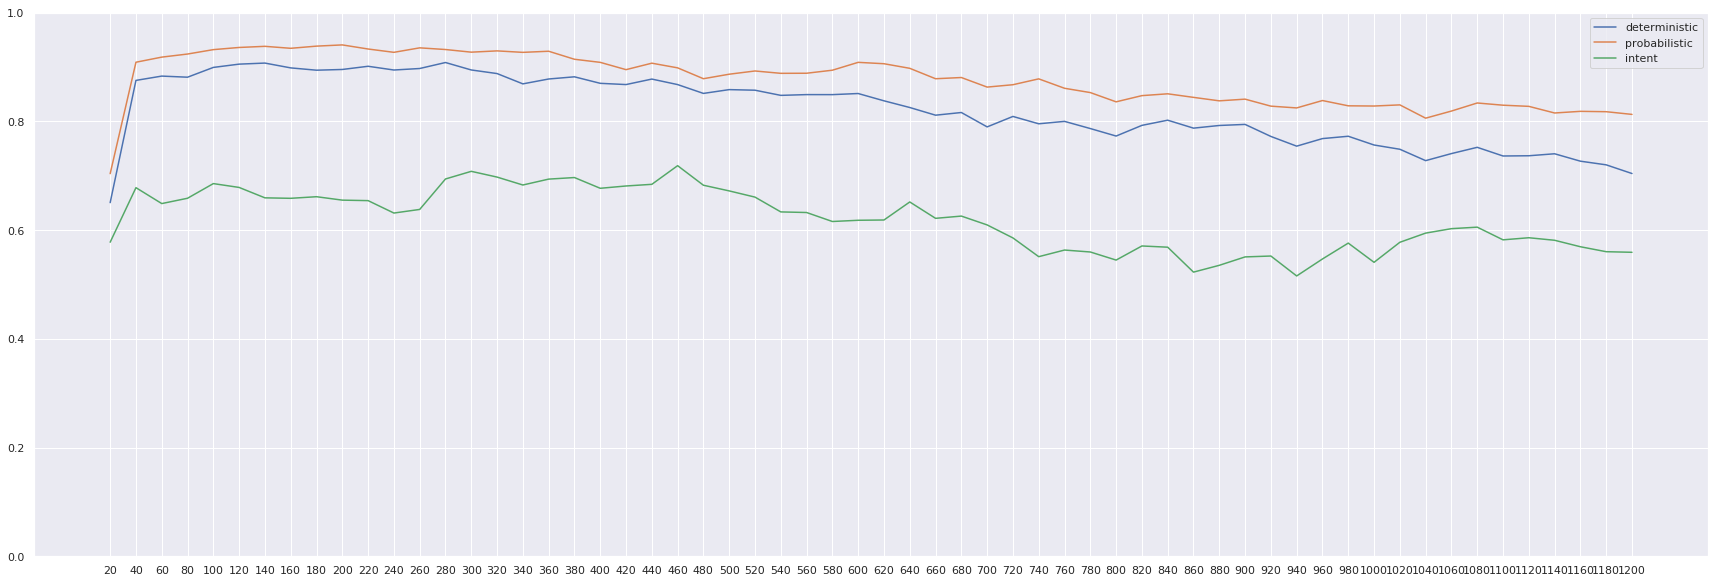

In [16]:
plt.figure(figsize=(30,10))

for ty in type_list:
    
    d = perf_dicts[ty]
    
    #load_obj('../scripts/perf_dict_%s.pkl' % ty)
    
    df1 = {}
    for k in d.keys():
        df1[k] = fx_score(d[k],2)
    
    la_times = list(df1.keys())
    scores = [df1[k] for k in df1.keys()]

    plt.plot(la_times, scores, label=ty)
    plt.ylim(bottom=0)
    
plt.legend()
plt.show()

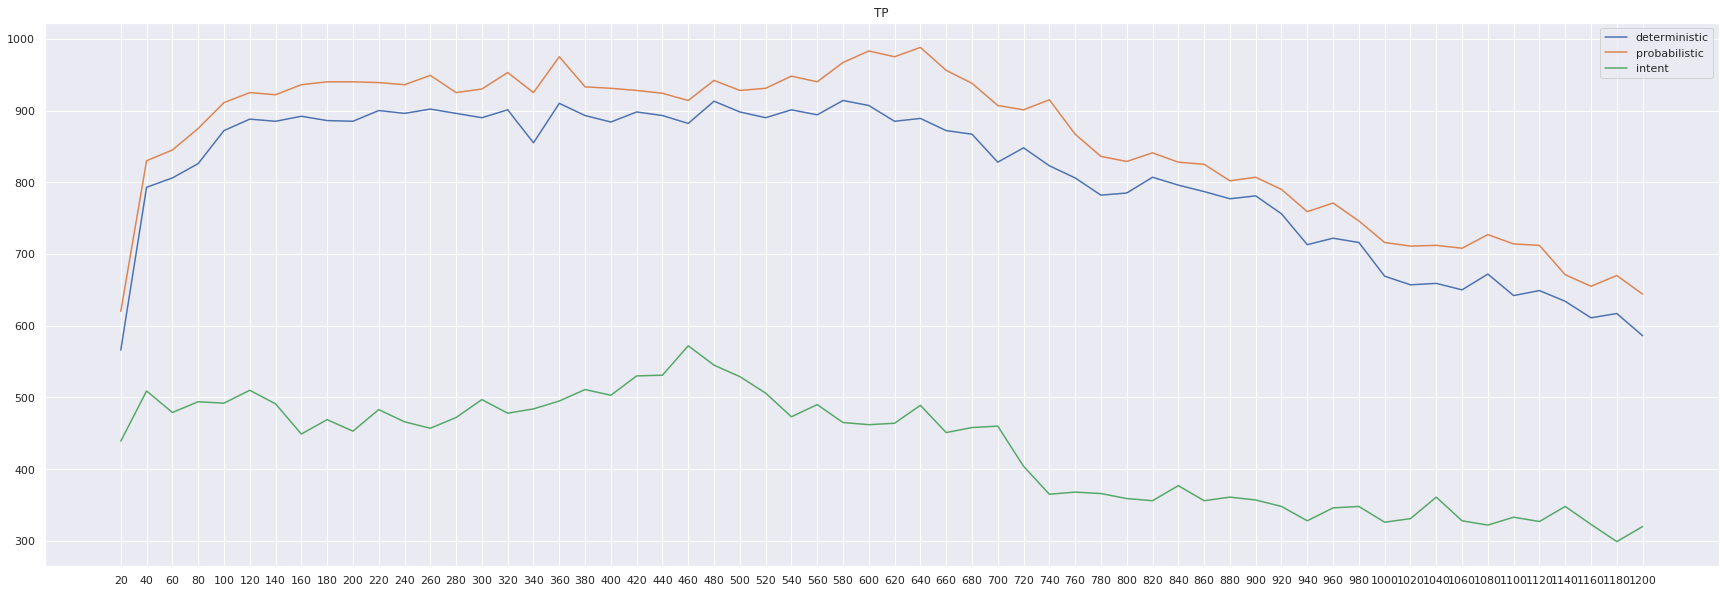

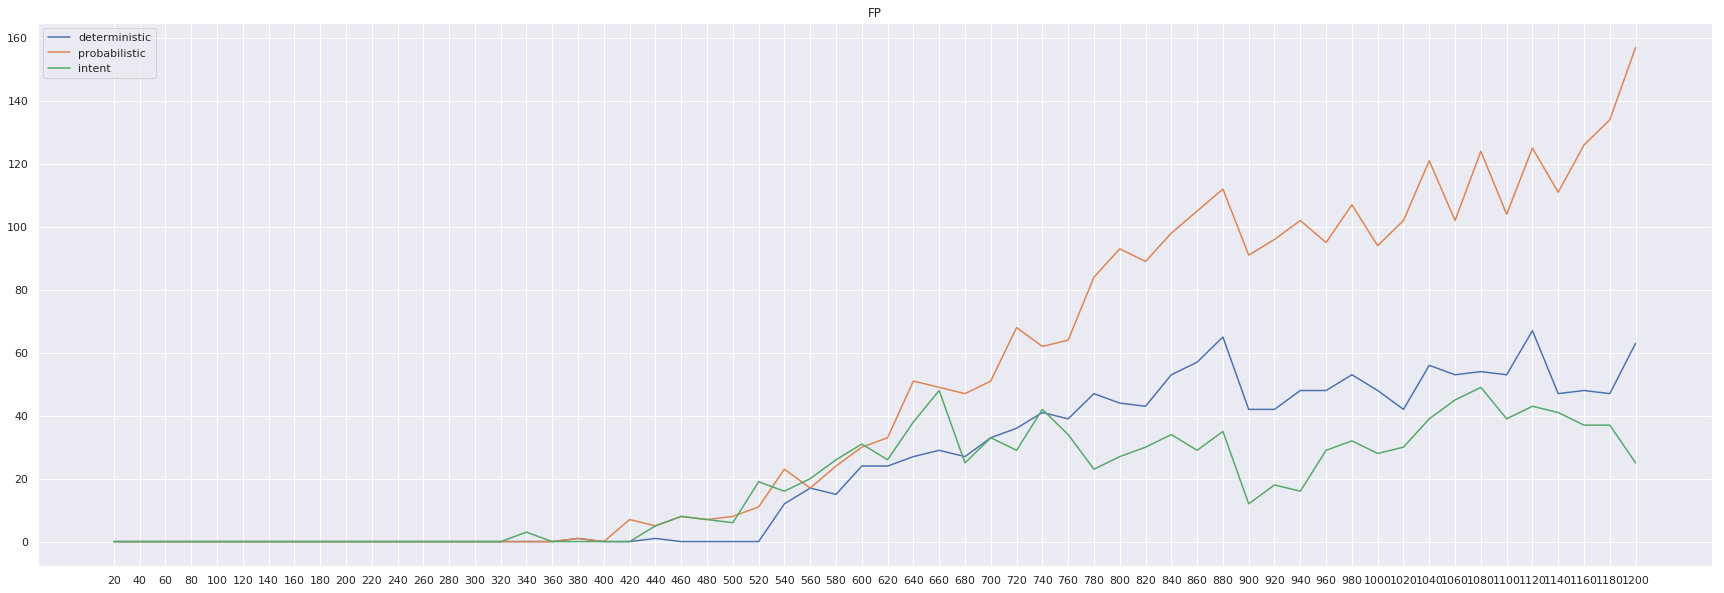

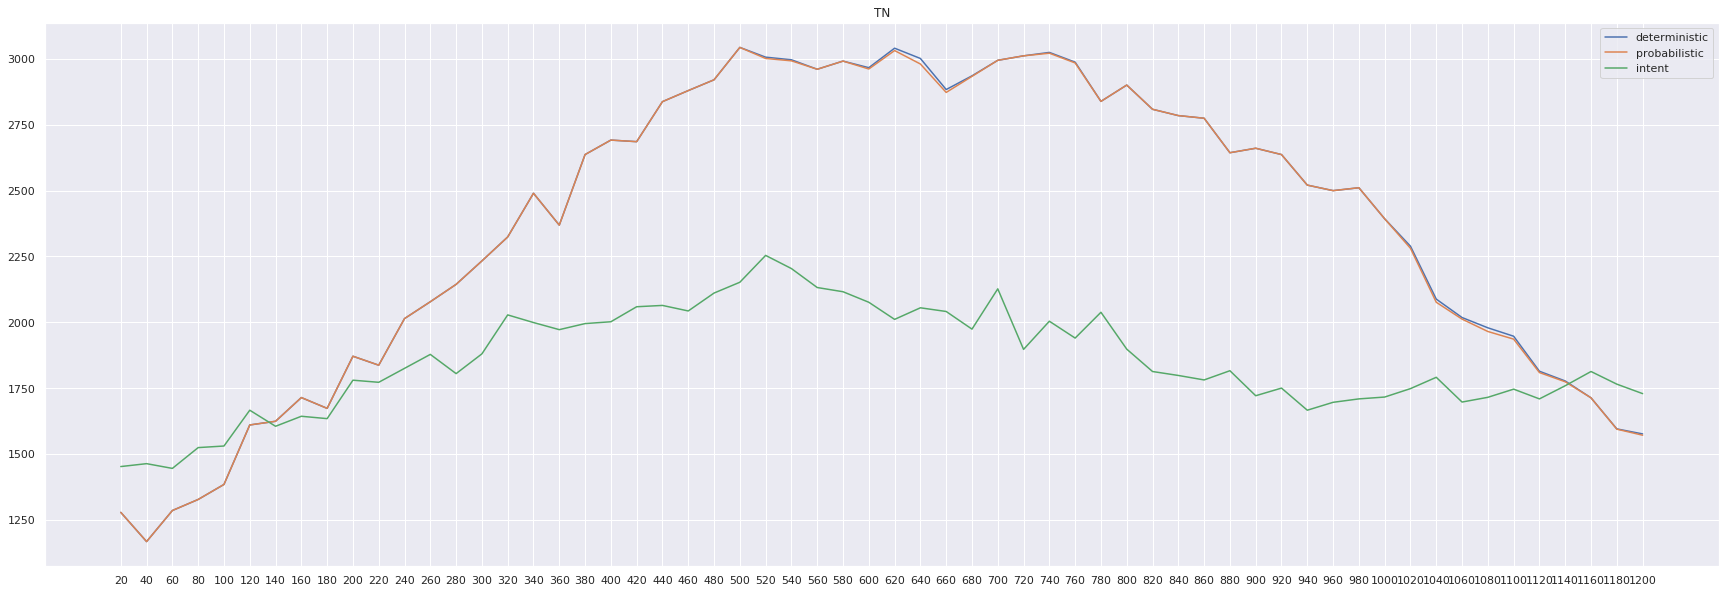

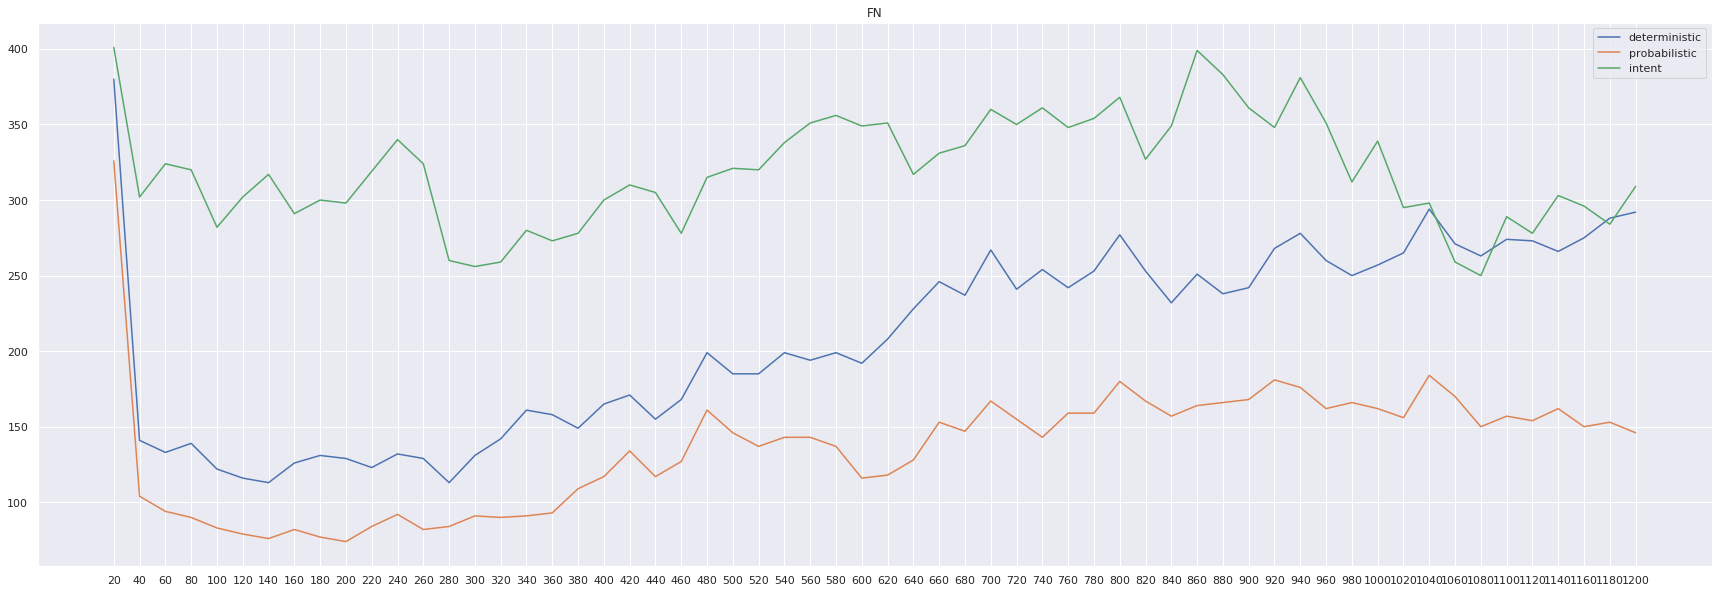

In [19]:
for ft in ['TP', 'FP', 'TN', 'FN']:
    plt.figure(figsize=(30,10))
    for ty in type_list:
        
        d = perf_dicts[ty]

        la_times = list(d.keys())
        cnt = sum([d[k][ft] for k in df1.keys()])
#         scores = [d[k][ft]/sum([d[k][ft] for ft in ['TP', 'FP', 'TN', 'FN']]) for k in df1.keys()]
        scores = [d[k][ft] for k in df1.keys()]
        
        plt.title(ft)
        plt.plot(la_times, scores, label=ty)
#         plt.ylim(bottom=-10)
        plt.legend()
    plt.show()

## Analyze TTC results

80421


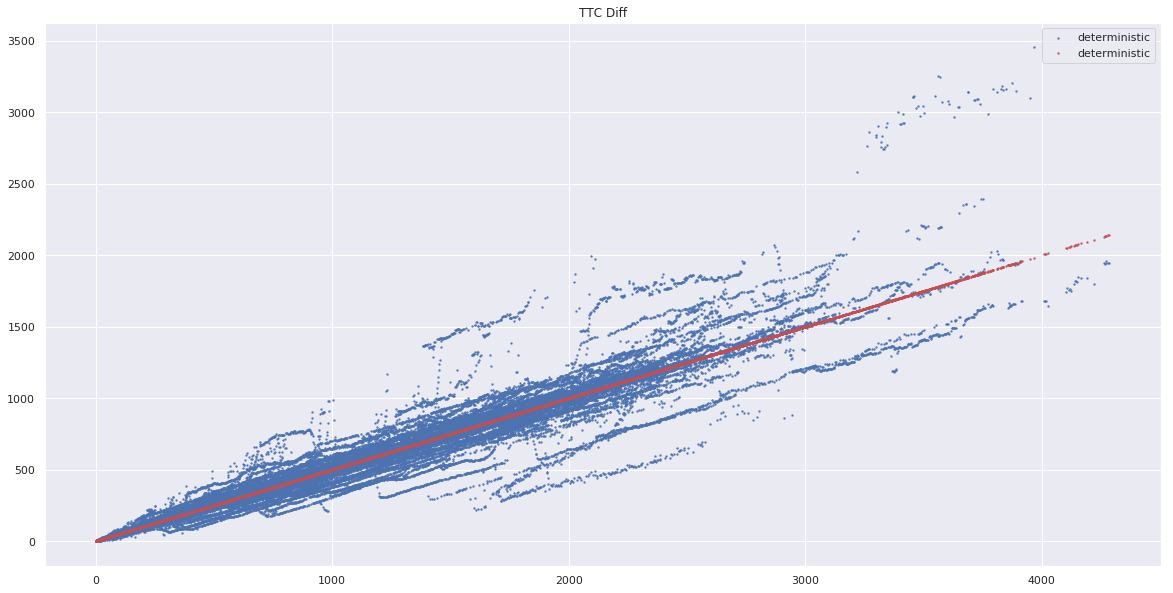

96577


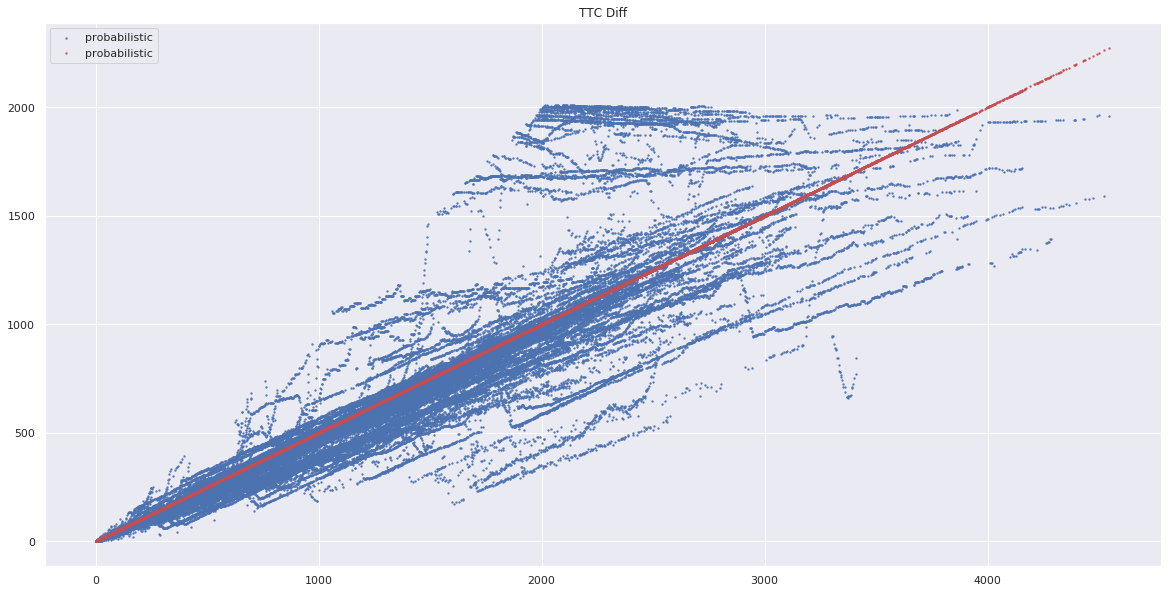

46829


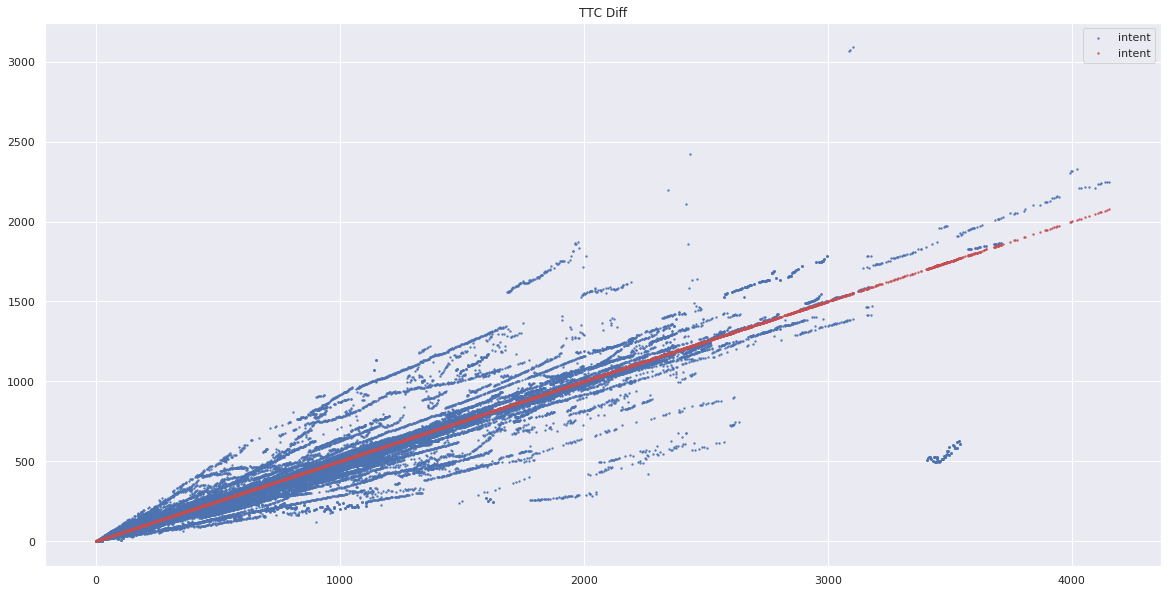

In [6]:
for ty in type_list:
    plt.figure(figsize=(20,10))
    d = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_act = []
    ttc_est = []
    ttc_diff = []
    la_t = []

    for v in d:
        if ~np.isnan(v[1]) and ~np.isnan(v[2]):
            ttc_act.append(v[1])
            ttc_est.append(v[2])
            ttc_diff.append(v[2] - v[1])
            la_t.append(v[0])


    plt.title('TTC Diff')
#     plt.xlim(0,1200)
#     plt.ylim(-20,100)
    plt.scatter(la_t, ttc_est, label=ty, s=2, alpha=0.8)
    plt.scatter(la_t, ttc_act, label=ty, s=2, alpha=0.8, color='r')
    print(len(ttc_est))
#     plt.ylim(-100,100)
    plt.legend()
    plt.show()

In [7]:
ty = 'intent'
d = load_obj('../scripts/ttc_list_%s.pkl' % ty)
fn_1 = len([v for v in d if ~np.isnan(v[2]) and ~np.isnan(v[1]) and v[1] <= la_time and ((v[2] - v[1]) > v[1]*0.1)])
fn_2 = len([v for v in d if np.isnan(v[2]) and ~np.isnan(v[1]) and v[1] <= la_time])
tp_1 = len([v for v in d if ~np.isnan(v[2]) and ~np.isnan(v[1]) and v[1] <= la_time and (-120 < (v[2] - v[1]) < v[1]*0.1)])

print(fn_1/fn_2)
print(fn_1 + fn_2)

0.2934223486921309
35454


In [8]:
list(range(5))

[0, 1, 2, 3, 4]

/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


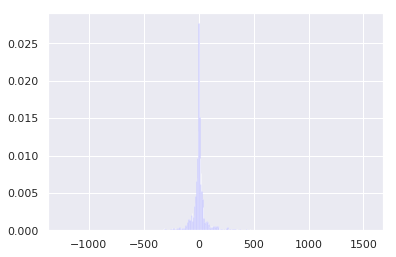

In [9]:
n, bins, patches = plt.hist(ttc_diff, bins=500, normed=1, facecolor='blue', alpha=0.5)

# plt.xlim(-100,100)
plt.show()

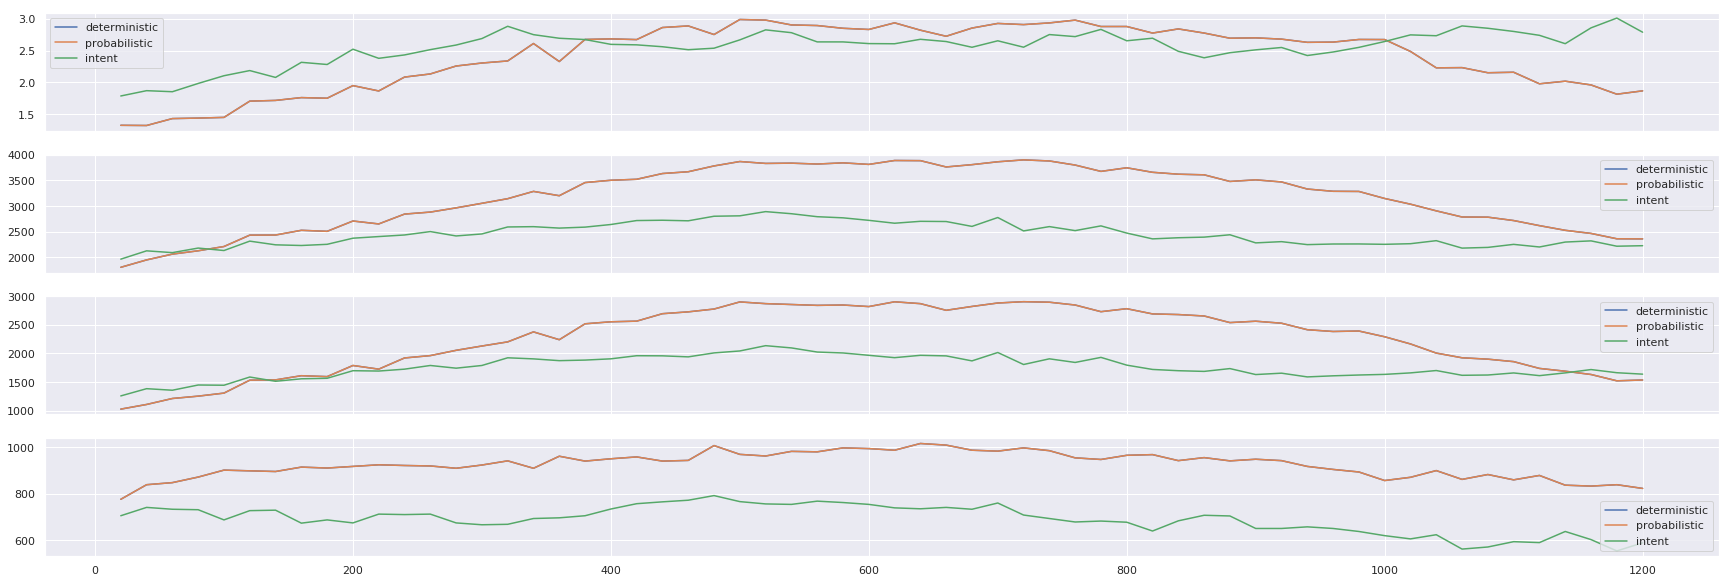

In [10]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(30,10))
# plt.figure()
bin_sec = 20
for ty in type_list:

    d = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_act = []
    ttc_est = []
    ttc_diff = []
    lat = 120
    ratios = []
    la_times = []
    pos = []
    neg = []
    
    count = []
    
    for b in range(int(1200 / bin_sec)):
        bmin = b * bin_sec
        bmax = bmin + bin_sec

        len_neg = len([v for v in d if np.isnan(v[1]) if bmin < v[0] < bmax])
        len_pos = len([v for v in d if ~np.isnan(v[1]) if bmin < v[0] < bmax])
        count.append(len_neg + len_pos)
        pos.append(len_pos)
        neg.append(len_neg)
        
        ratios.append(len_neg/len_pos)
        la_times.append(bmax)
        
#     ax1.title(ft)
    ax1.plot(la_times, ratios, label=ty)
    ax1.legend()
    
#     ax2.title(ft)
    ax2.plot(la_times, count, label=ty)
    ax2.legend()
    
    ax3.plot(la_times, neg, label=ty)
    ax3.legend()
    
    ax4.plot(la_times, pos, label=ty)
    ax4.legend()
    
plt.show()
        
    
#     print('%s negatives: %d' % (ty,len_neg))
#     print('%s positives: %d' % (ty,len_pos))
#     print('%s ratio: %f' % (ty,len_neg/len_pos))


<h2>Process Deterministic Conflicts</h2>

In [11]:
# cur_read = conn.cursor(cursor_factory=RealDictCursor)
# cur_read.execute("SELECT ts_1, ts_2, lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2 \
#                 FROM public.conflicts limit 100;")
# batch_1 = cur_read.fetchall()

# cur_read = conn.cursor(cursor_factory=RealDictCursor)
# cur_read.execute("SELECT ts_1, ts_2, lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2 \
#                 FROM public.converging_flights limit 100;")
# batch_2 = cur_read.fetchall()

In [12]:
# clist = ['b','g','k','m']

# fig = plt.figure(figsize=(20,20))

# for i,b in enumerate(batch_2[:20]):
    
#     plt.scatter(b['lat_1'], b['lon_1'], c=clist[i % 4])
#     plt.scatter(b['lat_2'], b['lon_2'], c=clist[i % 4])
#     plt.scatter(b['lat_2'][-1], b['lon_2'][-1],c='r')
#     plt.scatter(b['lat_1'][-1], b['lon_1'][-1],c='r')
#     plt.scatter(b['lat_2'][0], b['lon_2'][0],c='g')
#     plt.scatter(b['lat_1'][0], b['lon_1'][0],c='g')
# plt.show()

In [13]:
# for b in batch_2[10:30]:
#     print(b['ts_1'][-1] - b['ts_1'][0])
#     plt.figure(figsize=(10,10))
#     plt.scatter(b['lat_1'], b['lon_1'])
#     plt.scatter(b['lat_2'], b['lon_2'])
#     plt.show()

In [14]:
x = [1,2,3,4]

In [15]:
x[1:]

[2, 3, 4]